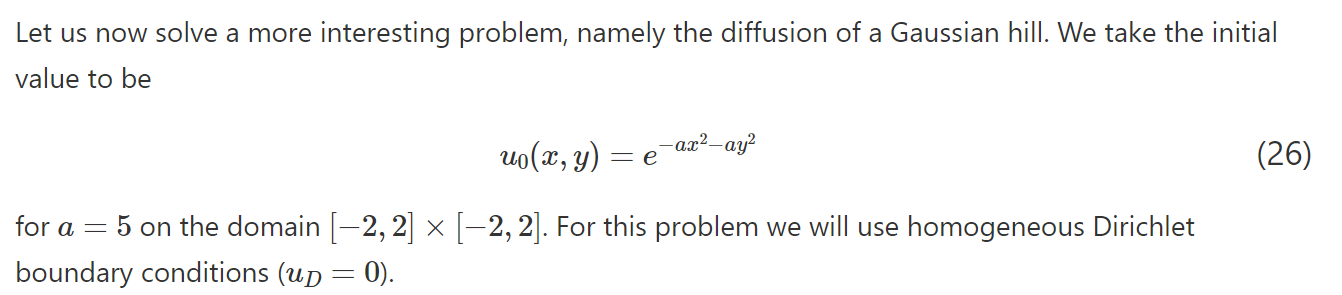

In [1]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import fem, mesh, io, plot

#Temporal parameters
t_0 = 0 # start time
t_1 = 2 # finish time
no_steps = 61
dt = t_1 / no_steps # time step size

#mesh
nx, ny = 50, 50
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([-2, -2]), np.array([2, 2])], 
                               [nx, ny], mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("CG", 1))


In [2]:
# Create Initial Conditions
def IC(x, a=5):
    return np.exp(- a * ( x[0] ** 2 + x[1] ** 2))
u_n = fem.Function(V)
u_n.name = "u_n"
u_n.interpolate(IC)

# Boundary Conditions
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    domain, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
BC = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(V, fdim, boundary_facets), V)




In [3]:
# Saving to a XDMF file
xdmf = io.XDMFFile(domain.comm, "diffusion.xdmf", "w")
xdmf.write_mesh(domain)

uh = fem.Function(V) # def. sol. variable and interpolate IC
uh.name = "uh"
uh.interpolate(IC)
xdmf.write_function(uh, t_0)

In [4]:
# Variational Problem and Solver
import ufl
from ufl import dx, dot, grad

u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
a = u * v * dx + dt * dot(grad(u), grad(v)) * dx
L = (u_n + dt * f) * v * dx
 

In [5]:
bilinear_form = fem.form(a) # fem.form generates assembly kernel for matrix and vector
linear_form = fem.form(L)

A, petsc_options = fem.assemble_matrix(bilinear_form, bcs=[BC]), {"ksp_type": "preonly", "pc_type": "lu"}
A.assemble() # matrix A on LHS of eq'n is time indep. so we need only assemble once
B, petsc_options = fem.create_vector(linear_form), {"ksp_type": "preonly", "pc_type": "lu"}

# Creating a linear Algebra solver 
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [6]:
# Plotting
import pyvista as pv
pv.set_jupyter_backend("ipygany")

grid = pv.UnstructuredGrid(*plot.create_vtk_mesh(V))

def f_plot(t_0, uh):
    p = pv.Plotter() #figure of concentration 'uh' warped visualised in 3D at t_0
    grid.point_data[f"u({t_0})"] = uh.x.array.real # updating points on pyvista grid
    warped = grid.warp_by_scalar(f"u({t_0})", factor=1.5) # warp mesy by point values
    
    fake = p.add_mesh(warped)
    if not pv.OFF_SCREEN:
        p.show()
    else: 
        pv.start_xvfb()
        fig_array = p.screenshot(f"diffusion_{t_0:, 2f}.png")
        
        p.remove_actor(fake)

f_plot(0, uh)
        

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0)</h3>'), Dropdown(description='Colormap:', options={'Br…

In [7]:
# To solve variational problem, we assemble RHS and apply BC before using solve

for i in range(no_steps):
    t_0 += dt
    
    with B.localForm() as locB: # update RHS using initial vector
        locB.set(0)
    fem.assemble_vector(B, linear_form) # don't supply BC for assembly because we want to use lifting to create BC,
                                        # which preserves of matrix A in bilinear form w/o Dirichlet BC
    
    
    fem.apply_lifting(B, [bilinear_form], [[BC]])
    B.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.set_bc(B, [BC]) # applying Dirichlet BC
    
    solver.solve(B, uh.vector) # solves linear problem
    uh.x.scatter_forward()
    
    u_n.x.array[:] = uh.x.array #update prev. time-step sol.
    
    xdmf.write_function(uh, t_0)  #write sol. to file
    
    if i % 15 == 0: #plotting every 15th time step
        f_plot(t_0, uh)

xdmf.close()

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0.03278688524590164)</h3>'), Dropdown(description='Colorm…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0.5245901639344261)</h3>'), Dropdown(description='Colorma…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(1.0163934426229513)</h3>'), Dropdown(description='Colorma…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(1.5081967213114764)</h3>'), Dropdown(description='Colorma…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(2.0000000000000013)</h3>'), Dropdown(description='Colorma…

## Comparison to Analytic Solution


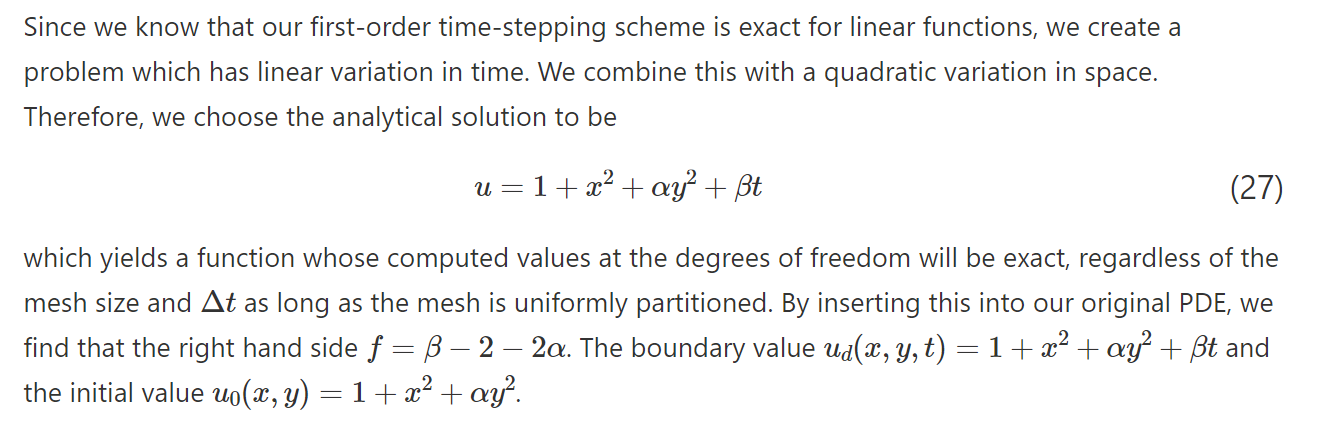
